In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import pickle
import os
import sys
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from scipy.optimize import minimize
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob
import time
import shutil


sys.path.insert(1, '../../modules')
# hand made functions
from Rouss1 import *
from Rouss2 import *
from Rouss3D import *
from ZoneBudget_ludo import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "working"
model_name = "test_Plio_multi"
exe_name= "../../exe/mf6"

In [3]:
#rivers paths
Agly_path = "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path = "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

#stations paths
Agly_stations = "../../data/Fleuves/stations_agly.csv" 
Tet_stations = "../../data/Fleuves/stations_tet2.csv"
Rea_stations = "../../data/Fleuves/stations_reart.csv"
Tech_stations = "../../data/Fleuves/stations_tech.csv"
Bol_stations = "../../data/Fleuves/stations_bol.csv"
Cant_stations = "../../data/Fleuves/stations_cant.csv"

In [4]:
# load dis infos
top,botm,idomain = read_pickle(os.path.join(model_dir,"export_dis"))

In [5]:
#spatial parameters

MNT_path = "../../data/surfaces_geoter/TOPO  (0 en mer).ASC"
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

nlay = idomain.shape[0]
ncol = idomain.shape[2]
nrow = idomain.shape[1]
res = 300

delr = np.ones(ncol)*res
delc = np.ones(nrow)*res

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data

In [6]:
# Do a list of all active cells
lst_domain = []
for ilay in range(nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            if idomain[ilay,irow,icol] == 1:
                lst_domain.append((ilay,irow,icol))


In [7]:
#uppermost active cell
Up_cells_act = up_act_cell(idomain)

In [46]:
# BC sea
# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/sea_bc_extended.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids3D(grid,BC_sea,idomain,type="polygon",idomain_active=True,layer=0)

# attribute a constant head at all the cells in the lst_chd
chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,-0.025*top[x[1],x[2]]))
    #chd_lst.append((x,0.1))

In [47]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.shp"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids3D(grid,etangs.dissolve(by="NATURE"),idomain,idomain_active=True,layer=1)

# attribute a constant head
elev = 0.1; et_drn_lst=[];
for x in etangs_chd:
    et_drn_lst.append((x,elev,1))

In [48]:
Agy_chd = Complete_riv(Agly_path,Agly_stations,28,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid,nlay=nlay)
Tech_chd = Complete_riv(Tech_path,Tech_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid,nlay=nlay)
Cant_chd = Complete_riv(Cant_path,Cant_stations,140,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid,nlay=nlay)
Rea_chd = Complete_riv(Rea_path,Rea_stations,100,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid,nlay=nlay)
Tet_chd = Complete_riv(Tet_path,Tet_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid,nlay=nlay)
Bol_chd = Complete_riv(Bol_path,Bol_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid,nlay=nlay)

lst_riv_chd=[Agy_chd,Tech_chd,Cant_chd,Rea_chd,Tet_chd,Bol_chd]
cond1=0.005
cond = [cond1,cond1,cond1,cond1,cond1,cond1]

for iriv in range(len(lst_riv_chd)):
    chd2riv(lst_riv_chd[iriv],cond[iriv],2)

C:\Users\emmal\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [49]:
# extraction
path = "../../data/prélèvements/BD_FORAGES_SMNPR/SMNPRV2.shp"

stress_data_well = importWells3D(path,grid,lst_domain,fac=1/365/86400,V_col="V_A_AEMRC", geol_col="NAPPE_CAPT",
                                 geol_layer=["PLIOCENE","QUATERNAIRE"],layer_num=[[3,5,7,9],1])

In [50]:
#cartes Benoit
folder = "../../data/T&K/Benoit"
lst_K_benoit = files_ext(folder,ends=".grd")

K=[]
for kp in lst_K_benoit:
    Rast = Raster.load(kp)
    K.append(Rast.resample_to_grid(grid.xcellcenters,
                          grid.ycellcenters,
                          band = Rast.bands[0],
                          method="nearest"))
K=10**np.array(K)
K[4][K[4]==float("inf")]=1e-5
K[5][K[5]==float("inf")]=1e-5

In [51]:
kp1 = K[0]
kp2 = (K[1]+K[2])/2
kp3 = (K[3]+K[4])/2
kp4 = K[5]

In [52]:
#permea
k = np.array([5e-4,5e-4,2.5e-9,kp1,
             2.5e-9,kp2,
             2.5e-9,kp3,
             2.5e-9,kp4,1e-5])

In [53]:
# control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using ImportControlPz3D (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
geol_layer = ["Quaternaire","Pliocène"]
geol_col = "AquifèreCapté"
Control_Pz = ImportControlPz3D(piez_path,sheet_name="2012",geol_layer=geol_layer,layer_num=[1,3],geol_col=geol_col,
                               grid=grid,nlay=nlay,np_col = "NP_Avril2013")

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [54]:
#recharge
rch_path = "../../data/recharge/rast_peff2.tif"
rcha = import_rch(rch_path,grid)

rch_lst=[]
for icell in Up_cells_act:
    irow = icell[1]
    icol = icell[2]
    rch_lst.append(((icell),rcha[irow,icol]/1000/365/86400))

In [55]:
## Thuir
BDcells = cellidBD(idomain,layer=3)

ix = GridIntersect(grid)
poly = Polygon([(674e3,616.8e4),(674e3,617.4e4),(678e3,617.4e4),(678e3,616.8e4)])
layer = 3
plio_chd = []
for cellid in ix.intersect_polygon(poly).cellids:
    cell = (layer,cellid[0],cellid[1])
    if cell in BDcells:
        plio_chd.append((cell,115))

In [56]:
# Corbières
BDcells = cellidBD(idomain,layer=3)
poly = Polygon([(685e3,618.7e4),(685e3,619.5e4),(696e3,619.5e4),(696e3,618.7e4)])
layer = 3
Corb_spd = []
Corb_lst = []
flux = 0.2
res = ix.intersect_polygon(poly)
for cellid in res.cellids:
    cell = (layer,cellid[0],cellid[1])
    if cell in BDcells:
        Corb_lst.append(cell)
n_cells = len(Corb_lst)

for cell in Corb_lst:
    Corb_spd.append((cell,flux/n_cells))

In [73]:
#drains
x0_d,y0_d,x1_d,y1_d = 690e3,616.5e4,700e3,617.3e4
poly = Polygon([(x0_d,y0_d),(x0_d,y1_d),(x1_d,y1_d),(x1_d,y0_d)])
layer = [1,3]
drn_lst=[]
res = ix.intersect_polygon(poly)

for cellid in res.cellids:
    for ilay in layer:
        cell = (ilay,cellid[0],cellid[1])
        if cell in Up_cells_act:
            drn_lst.append(((cell),top[cell[1],cell[2]]-5,1))
    

In [74]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='first3D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('BUDGET', 'ALL')])

# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k,save_flows=True)

#well
wel = fp.mf6.ModflowGwfwel(gwf,pname="wel",maxbound=len(stress_data_well),
                           stress_period_data=stress_data_well,save_flows=True)

# recharge
rch = fp.mf6.ModflowGwfrch(gwf,pname = "rch",maxbound=len(rch_lst),stress_period_data=rch_lst,save_flows=True)

#Corbières
Corb = fp.mf6.ModflowGwfwel(gwf,pname="Corb",filename="Corb.wel",maxbound=len(Corb_spd),
                            stress_period_data=Corb_spd,save_flows=True)

#zone Villeneuve
Vilnv = fp.mf6.ModflowGwfdrn(gwf,pname="villnv",filename="villnv.drn",maxbound=len(drn_lst),
                            stress_period_data=drn_lst,save_flows=True)

#constant heads
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

thuir = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='thuir', filename="thuir.chd", maxbound=len(plio_chd), 
                                                       stress_period_data={0: plio_chd}, save_flows=True)

#etangs
etangs = fp.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf,pname="eta",filename="eta.drn",maxbound=len(et_drn_lst),
                                              stress_period_data=et_drn_lst,save_flows=True)

#rivers
Agly = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf,pname="agly",filename="agly.riv",maxbound=len(Agy_chd),
                                                stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tet', filename="Tet.riv", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Rea', filename="Rea.riv", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Cant', filename="Cant.riv", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tech', filename="Tech.riv", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Bol', filename="Bol.riv", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)


In [75]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model test_Plio_multi...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package wel...
    writing package rch...
    writing package corb...
    writing package villnv...
    writing package sea...
    writing package thuir...
    writing package eta...
    writing package agly...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been ap

(True, [])

In [76]:
# retrieve the chd package name
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

rivfiles=[]
for file in os.listdir(model_dir):
    if file.endswith(".riv"):
        rivfiles.append(os.path.splitext(file)[0])

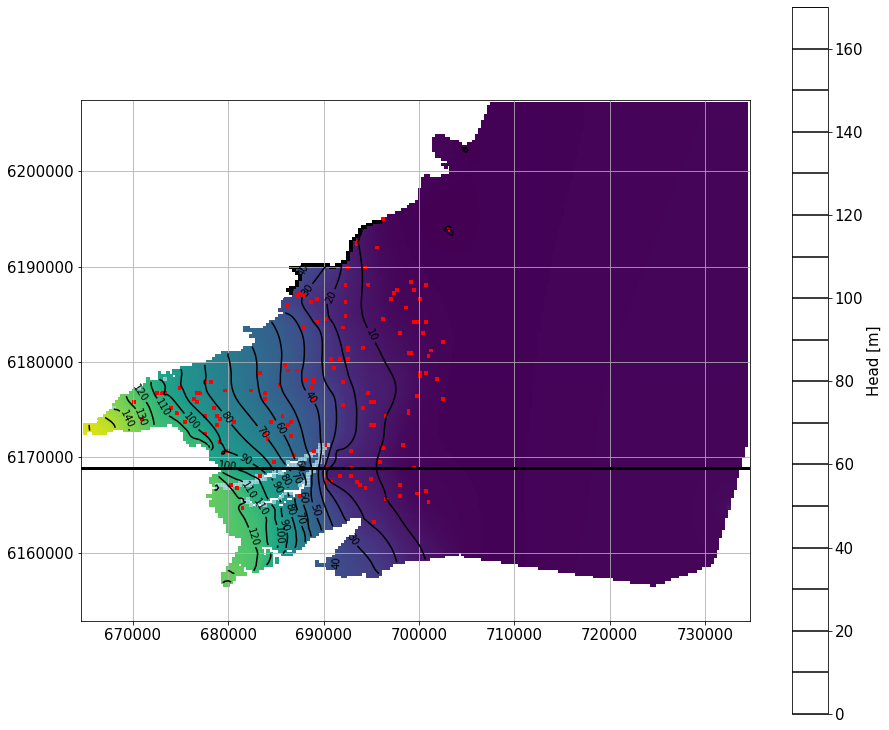

In [81]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)
#spdis = get_spdis(model_name,model_dir)

# make a plot
fig = plt.figure(figsize=(15,13))
layer = 3
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)

hmesh=ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,170)
cont = ml.contour_array(head[layer],masked_values=[0,1e30],levels=np.linspace(0,170,18),colors='black')
plt.clabel(cont,fmt="%1i")

# plot bc
ml.plot_bc("sea",color="b",alpha=0.5)

for riv in rivfiles:
    ml.plot_bc(riv,color="lightblue",alpha=0.5)

ml.plot_bc("eta",color="b",alpha=0.5)
ml.plot_bc("wel")
ml.plot_bc("Corb")

# plot Cross-section
row = 129
x = [x0,x1]
y = [y1-(row+.5)*delc,y1-(row+.5)*delc]
ax.plot(x,y,"k",linewidth=3)


ax.tick_params(labelsize=15)

g = plt.colorbar(cont)
g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)
ax.grid()

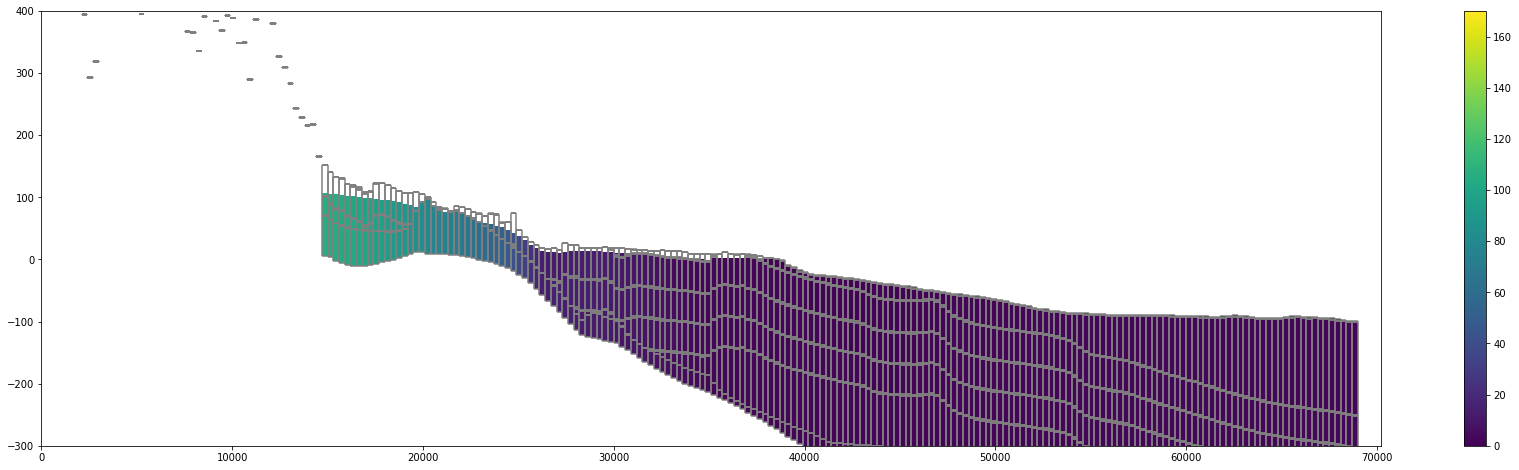

In [78]:
fig,ax = plt.subplots(figsize=(30,8))
x=fp.plot.PlotCrossSection(gwf,line={"row" :row})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
arr.set_clim(0,170)
x.plot_ibound()
x.plot_grid()
ax.set_ylim(-300,400)
x.plot_bc("sea")

TOTAL IN: 4.853978 m3/s
TOTAL OUT: 4.8535489 m3/s


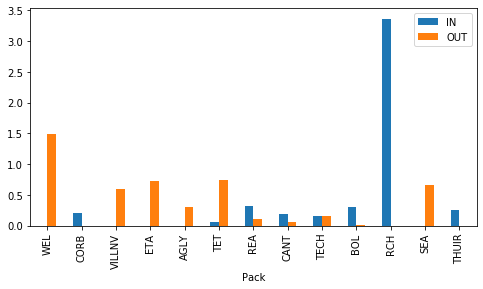

In [72]:
#total budget
fig,ax = plt.subplots(figsize=(8,4))
Budget = get_Total_Budget(model_name,model_dir)
Budget.set_index("Pack",inplace=True)
Budget.loc["SEA","IN":"OUT"] -= Budget.loc["SEA","IN"]
Budget.plot(kind="bar",ax=ax)
print("TOTAL IN: {} m3/s".format(Budget.sum()["IN"]));
print("TOTAL OUT: {} m3/s".format(Budget.sum()["OUT"]));

Misfit : 3.9573887178964813 m 


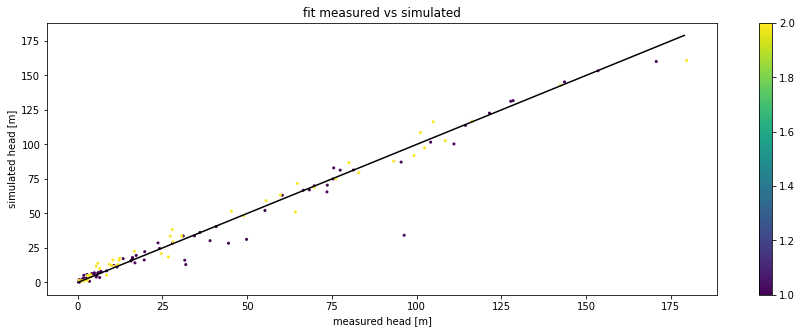

In [80]:
##make different color for each layer
color = np.ones([nlay,nrow,ncol])
color[1] = 1 # Q
color[3] = 2 # P
color = color.reshape(nlay*nrow*ncol)
##

Control_pz = Control_Pz.reshape(nlay*nrow*ncol)
head = head.reshape(nlay*nrow*ncol)
head[head>1000]=None

fig=plt.figure(figsize=(15,5))
plt.scatter(Control_pz[Control_pz!=0],
            head[Control_pz!=0],s=4,c = color[Control_pz!=0],cmap="viridis")

plt.plot(np.arange(180),np.arange(180),"k")
plt.xlabel("measured head [m]")
plt.ylabel("simulated head [m]")
plt.title("fit measured vs simulated")
Misfit = np.abs((Control_pz[Control_pz!=0] - head[Control_pz!=0]))
print("Misfit : {} m ".format(np.nanmean(Misfit)))
plt.colorbar()

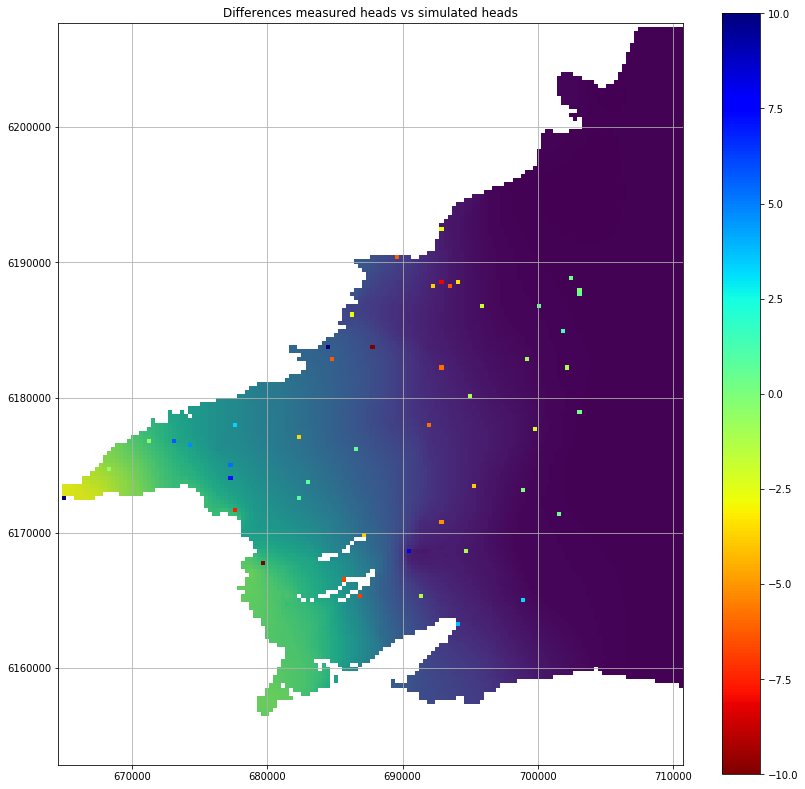

In [82]:
#errors map
layer=3
head = get_heads(model_name,model_dir)
head[head>1000]=None
fig,ax=plt.subplots(figsize=(14,14))
im=plt.imshow(head[layer],extent=[x0,x1,y0,y1])
im.set_clim(0,170)
head = head.reshape(nlay*nrow*ncol)
head[Control_pz==0]=None
a=plt.imshow((Control_pz - head).reshape(nlay,nrow,ncol)[layer],extent=[x0,x1,y0,y1],cmap="jet_r")

plt.title("Differences measured heads vs simulated heads")
plt.xlim(x0,x1-2.4e4)
plt.colorbar()
plt.grid()
ecart = 10
a.set_clim(-ecart,ecart)


In [28]:
def Misfit(kh):
    
    fp.mf6.mfpackage.MFPackage(gwf,package_type="npf").remove()# remove pre-existing npf package
    
    K = np.ones([nlay,nrow,ncol])
    K[0] = kh[0]
    K[1:8:2] = 0.25e-8
    K[2:10:2] = kh[1]
    K[9] = kh[2]
    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=K) # create the new npf package
    npf.write()
    
    if sim.run_simulation(silent = True): # And RUN !
        head = get_heads(model_name,model_dir)
        head[head>1000]=None
        head = head.reshape(nlay*nrow*ncol)
        
    return np.nanmean(np.abs((Control_pz[Control_pz!=0] - head[Control_pz!=0])))

In [ ]:
#minimize(Misfit,[1e-3,5e-5,1e-5],method="Nelder-Mead")

### budget by zones (in progress...)

In [ ]:
cbc = get_cbc(model_name,model_dir)

fname = os.path.join(model_dir, '{}.dis.grb'.format(model_name))
bgf = fp.utils.mfgrdfile.MfGrdFile(fname)
ia = bgf._datadict['IA'] - 1
ja = bgf._datadict['JA'] - 1

In [ ]:
flowja = cbc.get_data(text='FLOW-JA-FACE')[0][0, 0, :]
chdflow = cbc.get_data(text='CHD')[0]
riv2flow = cbc.get_data(text='riv')[1]

In [ ]:
def parr_pack(cbc,zones,layer,ip):
    
    nlay = zones.shape[0]
    nrow = zones.shape[1]
    ncol = zones.shape[2]
    
    arr = cbc.create3D(cbc.get_data(ip)[0],nlay,nrow,ncol).data[layer]
    mask = cbc.create3D(cbc.get_data(ip)[0],nlay,nrow,ncol).mask[layer]
    arr[mask]=None
    return arr

In [ ]:
def kij(n):
    return nn2kij(n,nlay,nrow,ncol)

i = 0; j = 104; k = 50
celln = i * nrow*ncol + j*ncol + k
q0=0

print('Printing flows for cell {}'.format(kij(celln + 1)))
for ipos in range(ia[celln] + 1, ia[celln + 1]):
    cellm = ja[ipos]  # change from one-based to zero-based
    print('Cell {} flow with cell {} is {}'.format(kij(celln + 1), kij(cellm + 1), flowja[ipos]))
    if flowja[ipos]>0:
        q0+=flowja[ipos]
print(q0)

In [ ]:
#create the zones
zones = np.zeros([nlay,nrow,ncol])
zones[0:2]=1
zones[2:8]=2
zones[9]=3
zones[idomain==0]=0

In [ ]:
#number of zones
nzones = get_nzones(zones)

In [ ]:
# get intercells interzones position
df_pos = get_dfpos(zones,ia,ja)

In [ ]:
FluxZZ = flow_zz(cbc,df_pos,zones,kstpkper=(0,0))

In [ ]:
# total budgets for 1st stress period
DF_pack = flow_pack(cbc,zones)

#append the two dataframes
df_zz = pd.DataFrame(FluxZZ)
col = np.zeros(nzones*2,dtype=int) # use same columns name because pd concat is stupid
df_zz.columns=col

DF_Budg = pd.concat([DF_pack,df_zz])# Union <3

In [ ]:
#index for the dataframe
pack_list = index_pack(cbc,zones,1)

In [ ]:
#create index, multicol, and have fun
lst_z=[]
for z in range(1,nzones+1):
    lst_z.append("zone {}".format(z))
columns = pd.MultiIndex.from_product([lst_z, ['FROM', 'TO']]) 
index = pack_list
DF_Budg = pd.DataFrame(DF_Budg.values,index=index,columns=columns)

In [ ]:
# remove excedent budget from sea
mask = DF_Budg.loc["SEA"]!=0
DF_Budg.loc["SEA"][mask] = DF_Budg.loc["SEA"][mask]-DF_Budg.loc["SEA"][mask].min()

In [ ]:
#plots

if os.path.exists('pictures'):
    shutil.rmtree('pictures')
os.makedirs("pictures")

z_list = DF_Budg.index[-nzones:]
I_O_list = ["TO","FROM"]


for z in z_list:
    for IN_OUT in I_O_list:
        fig,ax = plt.subplots(figsize=(9,9))
        labels = DF_Budg[DF_Budg[z][IN_OUT]!=0].index
        data = DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0].values
        data_pourc = DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0]/DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0].sum()
        
        wedges, texts,pct = ax.pie(data_pourc.values,pctdistance=0.8,
                                   wedgeprops=dict(width=0.5),autopct='%1.1f%%', startangle=0)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
        kw = dict(arrowprops=dict(arrowstyle="<-"),
                  bbox=bbox_props, zorder=0, va="center")
        xt = -5
        yt = -5
        ### arrows
        for i, p in enumerate(wedges):
            xta = xt
            yta = yt
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            xt = 1.3*np.sign(x)
            yt = 1.2*y
            if xt != xt:
                while((yta-yt)**2)< 0.01:
                    if yt >= yta:
                        yt += 0.01
                    else:
                        yt -= 0.01
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            annote = np.round(data[i],2)
            ax.annotate(annote, xy=(x, y), xytext=(xt,yt),
                        horizontalalignment=horizontalalignment, **kw)
        ###

        ax.set_title("{} : {}".format(z,IN_OUT))
        ax.set_position([0.1,0.1,0.5,0.7])
        ax.legend(wedges,labels,bbox_to_anchor=(1.5, 1))
        ax.text(-0.33,0,"TOTAL : {} m$^3/$s".format(np.round(data.sum(),3)))
        fig.savefig('pictures/{}_{}.png'.format(z,IN_OUT))
        plt.close()


In [ ]:
DF_Budg.replace(0,"/")